In [1]:
from google.cloud import storage
from google.cloud.storage.blob import Blob
import os

import pandas as pd
import numpy as np
from pprint import pprint
import string
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
import jieba

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import corpora, models, similarities

import pyLDAvis
import pyLDAvis.gensim

## Beijing

In [2]:
reviews_beijing = pd.read_csv("review_beijing.csv")
reviews_beijing.head()

,id,comments,listing_id,date,reviewer_id,reviewer_name,comments_nonnum
0,50889241,"非常美好的一次入住体验,我们两家带着孩子和老人一共五大两小,在那里住的非常舒服,还给宝宝熬了...",44054,2015-10-15,35112509,Rong,"非常美好的一次入住体验,我们两家带着孩子和老人一共五大两小,在那里住的非常舒服,还给宝宝熬了..."
1,54066571,"房间外面看的景色不错,就是洗澡的龙头有点高,房间很好.很舒服,第一次来北京,暖气很足~",44054,2015-11-15,33467823,Yanchen,"房间外面看的景色不错,就是洗澡的龙头有点高,房间很好.很舒服,第一次来北京,暖气很足~"
2,57494883,好!!,44054,2015-12-26,52128424,少晖,好!!
3,58954517,"非常好的居住体验,交通便利,设施齐全,我们的房间在最顶层,客厅看出去的夜景不错｡",44054,2016-01-05,51302195,李莉,"非常好的居住体验,交通便利,设施齐全,我们的房间在最顶层,客厅看出去的夜景不错｡"
4,63411437,"房子地理位置很方便,出了地铁7号线,走五分钟就能找到｡照片与实物一致,房间很干净,我们六个人...",44054,2016-02-22,23059634,Yu,"房子地理位置很方便,出了地铁号线,走五分钟就能找到｡照片与实物一致,房间很干净,我们六个人住..."


In [3]:
df = reviews_beijing.groupby("date")['id'].count().reset_index()
df_covid = df[(df.date>"2020-01-01") & (df.date<"2020-03-01")]

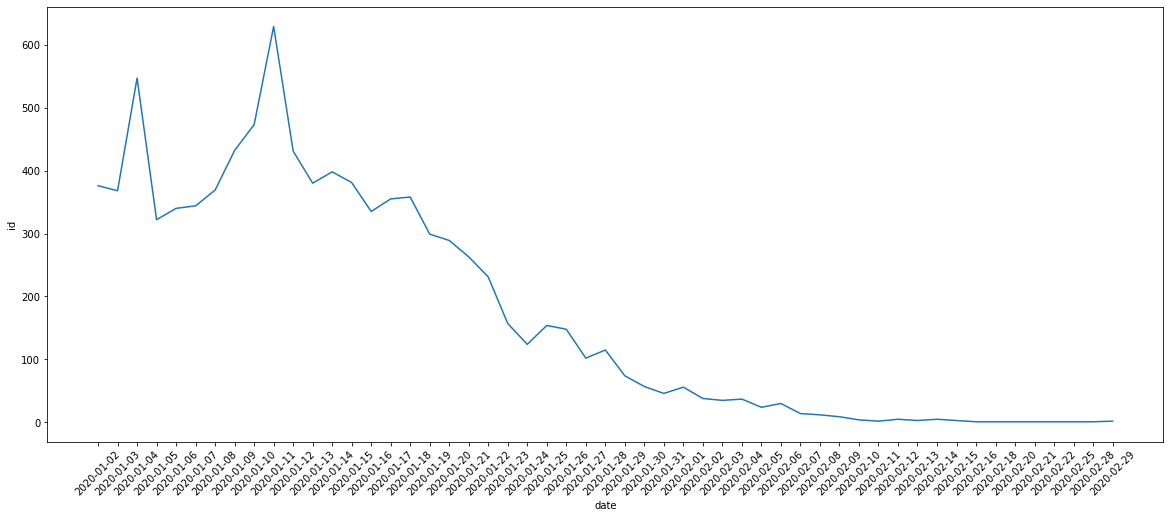

In [4]:
fig = plt.figure(figsize=(20,8))
plt.xticks(rotation=45)
sns.lineplot(df_covid.date, df_covid.id)

### Topics model

#### 1) comments cleaning

In [5]:
# load stopwords text file
with open("chinese_stop_words.txt") as f:
    stopwordList = f.readlines()

stopwordList = [x.strip() for x in stopwordList]

punctuations = list(string.punctuation)
# add additional stop words in Chinese
chinese_punct=['｡',"；",'','z','稍', "､", "", "挺", "想", "太", "特别", 
               "里", "说", "一点", "两个", "三个", "Airbnb"]
punctuations.extend(chinese_punct)
stopwordList.extend(punctuations)

In [6]:
# write the function to tokenize comments using jieba
def wordsLst(sentence):
    comment_token = jieba.cut(sentence.strip(), cut_all=False)
    tokens = ''
    for word in comment_token:
        if word not in stopwordList:
            if word != '\t' and word != '':
                tokens += word
                tokens += " "
    return tokens

In [7]:
tokens_lst = []
for i in reviews_beijing.comments_nonnum:
    if wordsLst(i) != '':
        tokens_lst.append([i, wordsLst(i)])

tokens_lst = [i[1].split(' ')[:-1] for i in tokens_lst]
tokens_lst

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.723 seconds.
Prefix dict has been built successfully.


[['美好',
  '入住',
  '体验',
  '两家',
  '孩子',
  '老人',
  '一共',
  '五大',
  '两小',
  '住',
  '舒服',
  '还给',
  '宝宝',
  '熬',
  '小米粥',
  '梨',
  '水',
  '在家',
  '旅途',
  '劳顿',
  '七号',
  '地铁线',
  '广渠门',
  '外',
  '东北',
  '口',
  '步行',
  '不到',
  '五分钟',
  '小区',
  '进出',
  '卡',
  '小区',
  '绿化',
  '服务',
  '到位',
  '阿姨',
  '热情周到',
  '打扫',
  '下次',
  '北京',
  '还会',
  '选择'],
 ['房间',
  '外面',
  '景色',
  '不错',
  '洗澡',
  '龙头',
  '高',
  '房间',
  '舒服',
  '第一次',
  '北京',
  '暖气',
  '很足'],
 ['居住', '体验', '交通', '便利', '设施', '齐全', '房间', '顶层', '客厅', '夜景', '不错'],
 ['房子',
  '地理位置',
  '地铁',
  '号线',
  '走',
  '五分钟',
  '找到',
  '照片',
  '实物',
  '房间',
  '干净',
  '六个',
  '人住',
  '两晚',
  '白天',
  '阿姨',
  '打扫',
  '浴室',
  '洗澡水',
  '很大',
  '热',
  '满意',
  '沙发',
  '坐下',
  '六个',
  '厨房',
  '餐具',
  '有锅',
  '总体',
  '满意',
  '住宿'],
 ['地段',
  '很棒',
  '高档',
  '小区',
  '中',
  '刷卡',
  '进出',
  '周边',
  '水果店',
  '找',
  '',
  '',
  '房子',
  '总体',
  '满意',
  '房间',
  '隔音',
  '不错',
  '晚上',
  '玩',
  '晚',
  '',
  '',
  '称心',
  '地方',
  '客厅',
  '空调',
  '坏',
  '找',
  '物业',
  '查

In [8]:
# create word dictionary
id2word = corpora.Dictionary(tokens_lst)
id2word.filter_extremes(no_below=1000, no_above=0.9, keep_n=5000)
corpus = [id2word.doc2bow(sentence) for sentence in tokens_lst]

In [9]:
# determine the number of topics
coherenceScores = []
models = []
# try the number of topics from 2 to 10
for num_topics in range(2,10,1):
    # build the lad model
    ldaModel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                    id2word=id2word,
                    num_topics=num_topics,
                    random_state=0,
                    update_every=1,
                    chunksize=100,
                    passes=10,
                    alpha='auto',
                    per_word_topics=True)
    models.append(ldaModel)
    # calculate the coherence score
    coherencemodel = CoherenceModel(model=ldaModel, texts=tokens_lst, 
                                    dictionary=id2word, coherence='c_v')
    coherenceScores.append(round(coherencemodel.get_coherence(),3))
    
print(coherenceScores)

[0.479, 0.501, 0.504, 0.507, 0.507, 0.475, 0.494, 0.48]


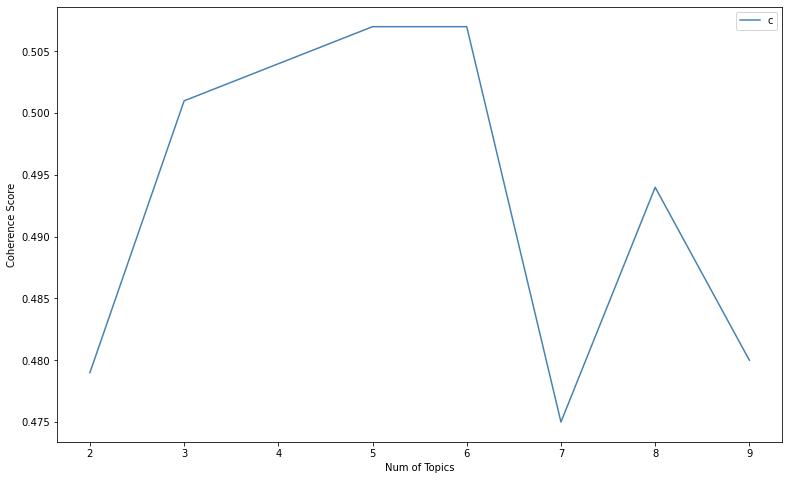

In [10]:
# plot the coherence scores against the number of topics
fig = plt.figure(figsize=(13,8))
x = range(2,10,1)
plt.plot(x, coherenceScores, color="steelblue")
plt.xlabel("Num of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherenceScores"), loc='best')
plt.show()

In [11]:
# find the index of the model with the highest coherence scores
best_idx = np.array(coherenceScores).argmax()
optimalModel = models[best_idx]
# print out representative words in each topic
model_topics = optimalModel.show_topics(formatted=False)
pprint(optimalModel.print_topics(num_words=15))

[(0,
  '0.064*"性价比" + 0.051*"高" + 0.041*"晚上" + 0.029*"卫生间" + 0.028*"走" + 0.026*"新" '
  '+ 0.022*"厨房" + 0.022*"找" + 0.021*"耐心" + 0.020*"老板" + 0.020*"总体" + '
  '0.020*"解决" + 0.017*"帮" + 0.016*"空调" + 0.015*"客厅"'),
 (1,
  '0.070*"超级" + 0.065*"地铁站" + 0.051*"交通" + 0.042*"地铁" + 0.041*"小区" + '
  '0.033*"楼下" + 0.033*"便利" + 0.032*"很近" + 0.030*"姐姐" + 0.029*"好找" + '
  '0.028*"nice" + 0.028*"房主" + 0.027*"图片" + 0.026*"吃" + 0.022*"暖气"'),
 (2,
  '0.908*"" + 0.028*"卫生" + 0.013*"价格" + 0.010*"提前" + 0.008*"三里屯" + 0.006*"夜景" '
  '+ 0.005*"by" + 0.004*"坐" + 0.004*"Hidden" + 0.004*"这是" + 0.004*"交流" + '
  '0.003*"便捷" + 0.002*"饭店" + 0.001*"️" + 0.000*"完"'),
 (3,
  '0.099*"房东" + 0.087*"房间" + 0.069*"干净" + 0.045*"房子" + 0.034*"入住" + 0.034*"不错" '
  '+ 0.032*"位置" + 0.027*"体验" + 0.026*"舒服" + 0.021*"热情" + 0.020*"整洁" + '
  '0.020*"温馨" + 0.017*"推荐" + 0.016*"小姐姐" + 0.016*"齐全"'),
 (4,
  '0.098*"住" + 0.050*"真的" + 0.048*"北京" + 0.044*"下次" + 0.038*"民宿" + 0.037*"感觉" '
  '+ 0.034*"喜欢" + 0.022*"还会" + 0.020*"地方" + 0.019*"朋友" + 0.

In [12]:
# visualize the topics
pyLDAvis.enable_notebook()
vis_title = pyLDAvis.gensim.prepare(optimalModel, corpus, id2word)
vis_title

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.240485 -0.001800       1        1  41.133118
4     -0.058057  0.241613       2        1  19.824923
2      0.241974 -0.330331       3        1  14.616776
1     -0.217680 -0.139658       4        1  12.768782
0      0.274248  0.230175       5        1  11.656402, topic_info=    Term           Freq          Total Category  logprob  loglift
53        325868.000000  325868.000000  Default  30.0000   30.000
77    房东  100412.000000  100412.000000  Default  29.0000   29.000
24    房间   88174.000000   88174.000000  Default  28.0000   28.000
3      住   47560.000000   47560.000000  Default  27.0000   27.000
42    干净   69377.000000   69377.000000  Default  26.0000   26.000
..   ...            ...            ...      ...      ...      ...
160   厕所    2797.283447    2798.110840   Topic5  -4.6280    2.149
26    洗澡    2773.813965    2774.639648   Topic5  -4.6364    2.149
67    隔音    2768.040527    2768.866943   Topic5  -4.6385    2.149
151   态度    2737.269531    2738.097168   Topic5  -4.6497    2.149
90    回来    2693.039062    2693.871338   Topic5  -4.6659    2.149

[203 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
53        3  0.999999        
386       3  0.999644  Hidden
103       2  0.998157  airbnb
387       3  0.999367      by
128       4  0.999919    nice
...     ...       ...     ...
360       2  0.999023      马桶
28        5  0.999969       高
35        1  0.999958      齐全
431       1  0.893344       ️
431       3  0.106038       ️

[176 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 2, 1])

In [13]:
pyLDAvis.save_html(vis_title, 'beijing_vis.html')

In [15]:
# Find the most representative sentence in each topic
pd.options.display.max_colwidth = 150
sent_topics_sorted = pd.DataFrame()
domin_sent = airbnb_beijing_dominant_topic.groupby('dominant_topic')

for i, sen in domin_sent:
    sent_topics_sorted = pd.concat([sent_topics_sorted, 
                                        sen.sort_values(['contribution_percent'], ascending=False).head(1)], 
                                        axis=0)
sent_topics_sorted.reset_index(drop=True, inplace=True)
sent_topics_sorted.columns = ['doc_no','topic_no', "contri_prob", "keywords", "repre_text"]
sent_topics_sorted

,doc_no,topic_no,contri_prob,keywords,repre_text
0,79095,0.0,0.559,"性价比,高,晚上,卫生间,走,新,厨房,找,耐心,老板","房间很棒,很舒服~房东负责,沟通及时,值得ʕ•ᴥ•ʔ"
1,102858,1.0,0.595,"超级,地铁站,交通,地铁,小区,楼下,便利,很近,姐姐,好找","真的非常干净,距离国家会议中心走路也就几分钟,很干净舒服"
2,38248,2.0,0.828,",卫生,价格,提前,三里屯,夜景,by,坐,Hidden,这是","设施很齐全,地理位置很方便,房东人很热情,房间整洁有序,完美｡"
3,18487,3.0,0.819,"房东,房间,干净,房子,入住,不错,位置,体验,舒服,热情","住宿周边环境好,安静｡房间宽敞明亮,住起来很舒畅,有独立卫生间｡房东亲切随和｡"
4,3135,4.0,0.740,"住,真的,北京,下次,民宿,感觉,喜欢,还会,地方,朋友","非常棒的改良四合院｡我们一行四家包了整个院子｡最喜欢那个温馨的客厅｡房间的被褥都很干净｡房东的父母非常热心,冰箱里满满的食物,看我们人多,中间还补货进去｡临走的时候还给孩子送了小礼物｡非常感谢你们的款待｡"


## San Francisco

In [18]:
reviews_sf = pd.read_csv("reviews_SF.csv")
reviews_sf.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five star experience. Holly and her husband, David, were the consummate hosts; friendly and accomodating wh..."
1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating thrill but this time it was enhanced by our stay at Holly and David's beautifully renovated and perfe...
2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations and the friendly neighborhood. Being able to make a second bed out of the futon couch was particularl...
3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agree with the previous postings: Holly and David were extremely helpful and friendly (but not at all in...
4,958,26008,2010-02-13,15416,Venetia,"Holly's place was great. It was exactly what I needed. Perfect location, super clean, and even a little patio out back. Since I go back to San Fr..."


In [19]:
# The 'shelter-in-place' policy in SF was executed since 17th Mar, 2020
df_sf = reviews_sf.groupby("date")['id'].count().reset_index()
df_covid_sf = df_sf[(df_sf.date>"2020-03-01") & (df_sf.date<"2020-06-07")]

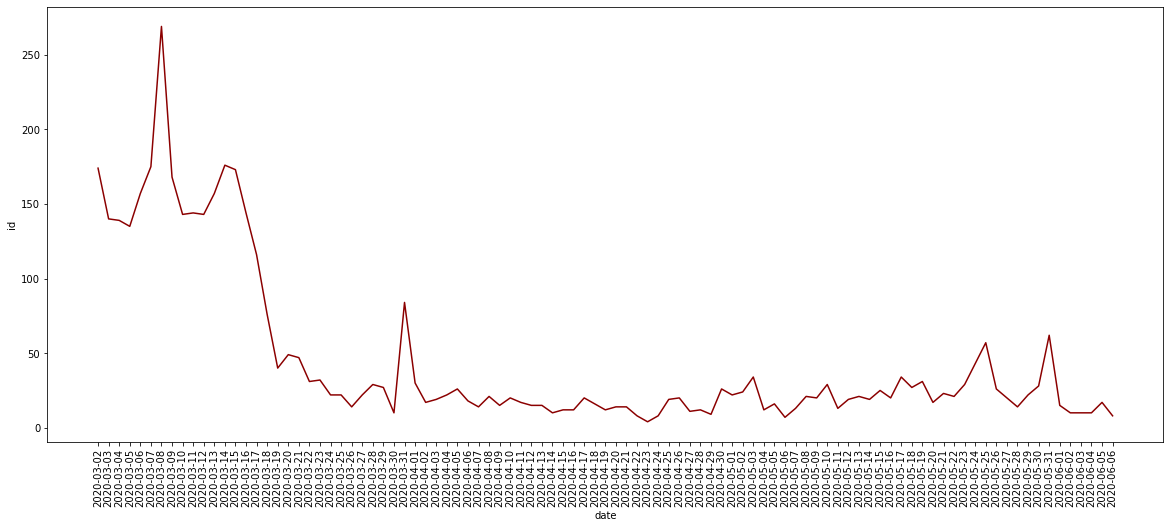

In [20]:
fig = plt.figure(figsize=(20,8))
plt.xticks(rotation=90)
sns.lineplot(df_covid_sf.date, df_covid_sf.id, color='darkred')